In [21]:
# Dependencies
import requests
import pandas as pd
from census import Census
import hvplot.pandas
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [22]:
# Import U.S. Census API Key
from config import api_key

# Create an instance of the Census library
c = Census("fbf85c344ae6d1e95862540efdd1b746ecfce696")

In [23]:
# Variables 
#B08301_001E is the estimated total workers
#B08301_021E is the estimated workers who worked from home

variables = ['B08301_001E', 'B08301_021E']

# Years we are looking at
years = [2020, 2021, 2022]

# FIPS code to state names
names_state = {
    '01': 'Alabama', '02': 'Alaska', '04': 'Arizona', '05': 'Arkansas', '06': 'California',
    '08': 'Colorado', '09': 'Connecticut', '10': 'Delaware', '11': 'District of Columbia',
    '12': 'Florida', '13': 'Georgia', '15': 'Hawaii', '16': 'Idaho', '17': 'Illinois',
    '18': 'Indiana', '19': 'Iowa', '20': 'Kansas', '21': 'Kentucky', '22': 'Louisiana',
    '23': 'Maine', '24': 'Maryland', '25': 'Massachusetts', '26': 'Michigan', '27': 'Minnesota',
    '28': 'Mississippi', '29': 'Missouri', '30': 'Montana', '31': 'Nebraska', '32': 'Nevada',
    '33': 'New Hampshire', '34': 'New Jersey', '35': 'New Mexico', '36': 'New York', '37': 'North Carolina',
    '38': 'North Dakota', '39': 'Ohio', '40': 'Oklahoma', '41': 'Oregon', '42': 'Pennsylvania',
    '44': 'Rhode Island', '45': 'South Carolina', '46': 'South Dakota', '47': 'Tennessee', '48': 'Texas',
    '49': 'Utah', '50': 'Vermont', '51': 'Virginia', '53': 'Washington', '54': 'West Virginia',
    '55': 'Wisconsin', '56': 'Wyoming', '72': 'Puerto Rico'
}

# List to store the data for all years
all_states = []

# Loop through each year 
for year in years:
    # Get the data for all states for this year
    data = c.acs5.get(variables, geo={"for": "state:*"}, year=year)
    
    # Convert the data to a DataFrame
    wfh_df = pd.DataFrame(data[1:], columns=data[0])
    
    # Add the year as a column to the DataFrame
    wfh_df['year'] = year
    
    # Map the state FIPS codes to state names
    wfh_df['names_state'] = wfh_df['state'].map(names_state)
    
    # Append this year's data to the all_data list
    all_states.append(wfh_df)

# Now, create the DataFrame 
wfh_df = pd.concat(all_states, ignore_index=True)

# Display the columns: State Name, Year, Total Workers, Workers Who Work From Home
wfh_df = wfh_df[['names_state', 'year', 'B08301_001E', 'B08301_021E']]

# Rename the columns for clarity
wfh_df.columns = ['State', 'Year', 'Total Workers', 'Workers Who Work From Home']

# Convert the 'Total Workers' and 'Workers Who Work From Home' columns to numeric values because strings will prevent numeric operations
wfh_df['Total Workers'] = wfh_df['Total Workers'].astype(int)
wfh_df['Workers Who Work From Home'] = wfh_df['Workers Who Work From Home'].astype(int)

# Calculate the percentage of workers who work from home
wfh_df['Percentage of Workers Who Work From Home'] = (
    wfh_df['Workers Who Work From Home'] / wfh_df['Total Workers']
) * 100

# Format the percentage column to two decimal places
wfh_df['Percentage of Workers Who Work From Home'] = wfh_df['Percentage of Workers Who Work From Home'].apply(lambda x: "{:.2f}%".format(x))

# Display the DataFrame
wfh_df

,State,Year,Total Workers,Workers Who Work From Home,Percentage of Workers Who Work From Home
0,California,2020,18239892,1529697,8.39%
1,West Virginia,2020,730395,33353,4.57%
2,Utah,2020,1517044,138218,9.11%
3,New York,2020,9219025,634197,6.88%
4,District of Columbia,2020,379090,46472,12.26%
...,...,...,...,...,...
148,Washington,2022,3722716,575184,15.45%
149,West Virginia,2022,723217,49655,6.87%
150,Wisconsin,2022,2974249,300409,10.10%
151,Wyoming,2022,284555,21902,7.70%


In [24]:
#Ensure the 'Percentage of Workers Who Work From Home' column is numeric
wfh_df['Percentage of Workers Who Work From Home'] = wfh_df['Percentage of Workers Who Work From Home'].apply(
    lambda x: float(x.replace('%', '').replace(',', '')) if isinstance(x, str) else x
)

# Handle NaNs in the Percentage calculation
wfh_df['Percentage of Workers Who Work From Home'] = wfh_df['Percentage of Workers Who Work From Home'].fillna(0)

#Group by 'State' and 'Year' and calculate the mean
mean_df = wfh_df.groupby(['State', 'Year'])['Percentage of Workers Who Work From Home'].mean().reset_index()

#Pivot the data
wfh_percentage_df = mean_df.pivot(index='State', columns='Year', values='Percentage of Workers Who Work From Home')

#Fill any NaN values with 0
wfh_percentage_df = wfh_percentage_df.fillna("0")

# Clean up the column name
wfh_percentage_df.columns = [f"Percentage of Workers Who Work From Home ({year})" for year in wfh_percentage_df.columns]

#Format the values back to percentage
wfh_percentage_df = wfh_percentage_df.map(lambda x: f"{x:.2f}%" if isinstance(x, (float, int)) else x)

# Reset index to make 'State' a column
wfh_percentage_df.reset_index(inplace=True)

# Display the Dataframe
wfh_percentage_df

,State,Percentage of Workers Who Work From Home (2020),Percentage of Workers Who Work From Home (2021),Percentage of Workers Who Work From Home (2022)
0,Alabama,4.43%,0,0
1,Alaska,6.03%,7.09%,8.06%
2,Arizona,8.88%,11.71%,14.26%
3,Arkansas,4.37%,5.63%,6.75%
4,California,8.39%,11.36%,13.63%
5,Colorado,10.80%,13.99%,16.49%
6,Connecticut,7.64%,10.40%,12.61%
7,Delaware,7.15%,9.84%,11.64%
8,District of Columbia,12.26%,19.83%,25.03%
9,Florida,7.76%,9.87%,11.94%


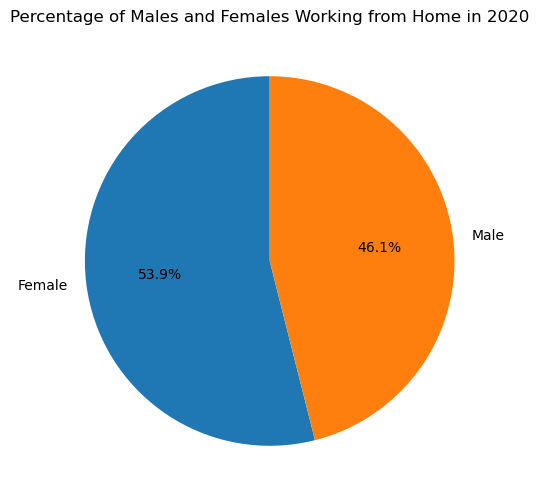

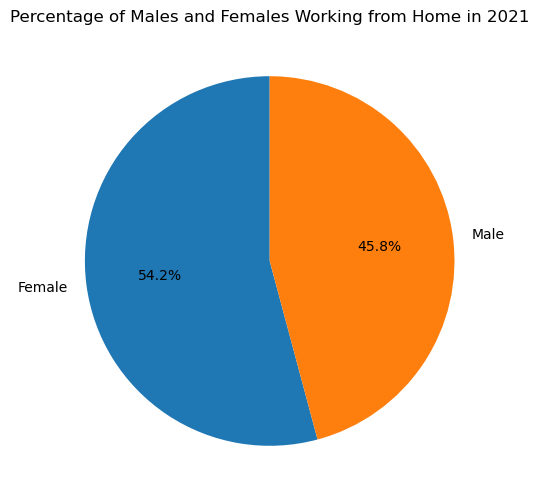

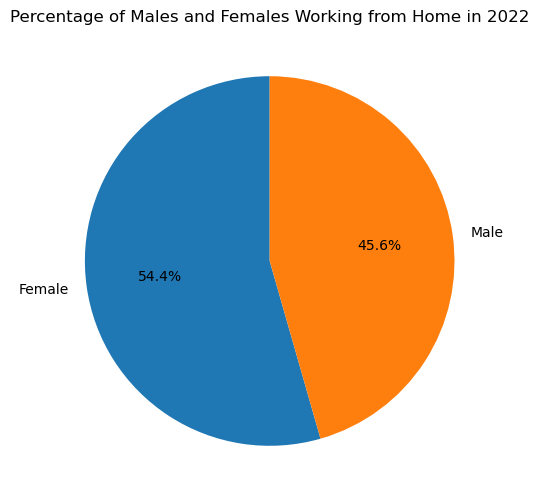

,2020 Female Percentage Worked From Home,2020 Male Percentage Worked From Home,2021 Female Percentage Worked From Home,2021 Male Percentage Worked From Home,2022 Female Percentage Worked From Home,2022 Male Percentage Worked From Home
State,,,,,,
Alabama,4.88%,4.20%,6.18%,5.32%,7.45%,6.17%
Alaska,7.46%,4.67%,9.07%,5.27%,10.16%,6.15%
Arizona,10.13%,7.94%,13.22%,10.60%,16.10%,12.92%
Arkansas,4.78%,4.01%,6.11%,5.19%,7.40%,6.17%
California,9.31%,7.61%,12.53%,10.37%,15.02%,12.47%
Colorado,12.00%,9.83%,15.38%,12.89%,18.03%,15.25%
Connecticut,8.15%,7.51%,11.22%,10.15%,13.68%,12.31%
Delaware,7.15%,7.18%,10.12%,9.61%,12.25%,11.14%
District of Columbia,6.35%,5.09%,10.72%,8.37%,13.92%,11.08%


In [27]:
# Variables for male and female workers
gender_total = {
    'Male': {
        'total_workers': 'B08406_018E',
        'wfh_workers': 'B08406_034E'
    },
    'Female': {
        'total_workers': 'B08406_035E',
        'wfh_workers': 'B08406_051E'
    }
}

# Years we are looking at
years = [2020, 2021, 2022]

# List to store data for all years
all_data_gender = []

# Loop through each year to get data for males and females
for year in years:
    for gender in gender_total:
        # Get the codes for the total workers and worked from home workers
        total_workers_code = gender_total[gender]['total_workers']
        wfh_workers_code = gender_total[gender]['wfh_workers']
        
        # Get the data for all states for this year and sex
        data = c.acs5.get([total_workers_code, wfh_workers_code], geo={"for": "state:*"}, year=year)
        
        # Process the data into a structured format
        for row in data:
            state_code = row['state']
            state_name = names_state.get(state_code, 'Unknown')
            total_workers = row.get(total_workers_code, None)
            wfh_workers = row.get(wfh_workers_code, None)
            
            # Calculate the percentage of workers working from home
            if total_workers and total_workers > 0:
                percentage_wfh = (wfh_workers / total_workers) * 100 if wfh_workers else 0
            else:
                percentage_wfh = 0
            
            # Only append the relevant data (we don't need 'Total Workers' or 'Worked From Home')
            gender_data = {
                'State': state_name,
                'Year': year,
                'Gender': gender,
                'Percentage Worked From Home': percentage_wfh
            }
            
            # Append the data for this state and sex to the all_data_sex list
            all_data_gender.append(gender_data)

# Convert the collected data into a pandas DataFrame
gender_df = pd.DataFrame(all_data_gender)

# Clean the DataFrame (convert values to numeric where necessary)
gender_df['Percentage Worked From Home'] = pd.to_numeric(gender_df['Percentage Worked From Home'], errors='coerce')

# Pivot the data so that each year/sex combination has its own column
gender_percentage_df = gender_df.pivot_table(
    index='State', 
    columns=['Year', 'Gender'], 
    values='Percentage Worked From Home', 
    aggfunc='mean'
)

# Flatten the multi-level columns for easier access
gender_percentage_df.columns = [f"{year} {gender} Percentage Worked From Home" for year, gender in gender_percentage_df.columns]

# Format the percentage columns to show 2 decimal places and add the '%' symbol
gender_percentage_df = gender_percentage_df.map(lambda x: f"{x:.2f}%" if pd.notnull(x) else None)

# Display the DataFrame
gender_percentage_df

for year in years:
    # Filter data for the specific year
    year_data = gender_df[gender_df['Year'] == year]
    
    # Aggregate percentage for each gender
    gender_wfh = year_data.groupby('Gender')['Percentage Worked From Home'].mean()
    
    # Plot the pie chart
    plt.figure(figsize=(6, 6))
    plt.pie(
        gender_wfh, 
        labels=gender_wfh.index, 
        autopct='%1.1f%%', 
        startangle=90
    )
    plt.title(f"Percentage of Males and Females Working from Home in {year}")
    plt.show()

from IPython.display import display
display(gender_percentage_df)